# Sentiment Analysis of Stocks

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import time
import re
import numpy as np
import nltk
import requests
import random
from collections import defaultdict
from bs4 import BeautifulSoup
from nltk.sentiment.vader import SentimentIntensityAnalyzer

## Part I: Scrape news

In [ ]:
class WebScrapper(BeautifulSoup):
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36 Edg/119.0.0.0',
               'Connection':'close'}

    def __init__(self, url, **kwargs):
        
        time.sleep(np.random.randint(10, high=16))
        
        resp = requests.get(url, headers=self.headers)
        assert resp.status_code==200, f"req not successfull: {resp.status_code}"
        super().__init__(resp.content, "html.parser", **kwargs)
        

    def extract(self, name=None, attrs={}, **kwargs):
        content = super().find(name=name, attrs=attrs, **kwargs).find_all('p')

        texts = []
        for par in content:
            texts.append(par.get_text())
        extracted_text = " ".join(texts)

        return extracted_text

In [ ]:
days = np.arange(1,32)
dates = [f'2023-10-{d:02d}' for d in days]
dates.append('2023-11-01')

companies = ["VISA Inc", "UnitedHealth Group Inc",
             "Verizon Communications Inc", "Adobe Inc"]

# Define the URL of the articles on Yahoo.com
_dict = defaultdict(list)

for company in companies:
    print(f'{company}:', end='')
    
    for j in range(len(dates) - 1):
        url = f"https://www.google.com/search?q={company} site:yahoo.com after:{dates[j]} before:{dates[j+1]} -AVI -FLV -WMV -MOV -MP4 -jpg -jpeg -png"
        
        ws = WebScrapper(url)
        links = ws.find_all("a")

        count = 0
        for link in links:
            try:
                if link['href'][:30] == 'https://finance.yahoo.com/news' or link['href'][:26] == 'https://www.yahoo.com/news':
                    _dict[(company, dates[j])].append(link["href"])
                    count += 1
                if count == 2: # number of articles
                    break
            except:
                pass
        print('.', end='')
    print('')
np.save('links_new.npy', _dict)

    
    
results = {}
for k, v in _dict.items():
    
    for url in v:
        
        ws = WebScrapper(url)
        text = ws.extract('div', class_='caas-body')
        
        sia = SentimentIntensityAnalyzer()
        scores = sia.polarity_scores(text)
        
        if k in results:
            for name, score in scores.items():
                results[k][name] += score
                results[k][name] /= 2
                results[k][name] = round(results[k][name], 4)
        else:
            results[k] = scores
        time.sleep(5)
    print('.', end='')    
    
df = pd.DataFrame.from_dict(results, orient='index')
df.to_csv('sentiment_scores_mehdi.csv')    

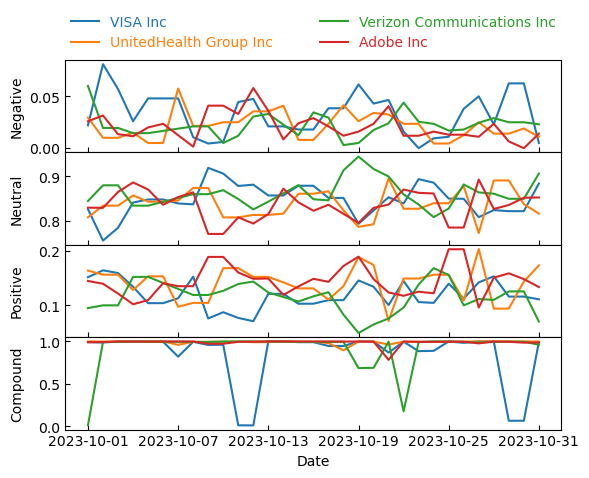

In [127]:
columns = ['Negative', 'Neutral', 'Positive', 'Compound']
fg, ax = plt.subplots(nrows=4, sharex=True)

for col in range(df.shape[1]):
    
    for c, company in enumerate(companies):

        # select rows
        list_ix = []
        list_dates = []
        for i, ix in enumerate(df.index):
            if ix[0]==company:
                list_ix.append(i)
                list_dates.append(ix[1])

        ax[col].plot(list_dates, df.iloc[list_ix, col], label=company)

    ax[col].set_ylabel(columns[col])
    ax[col].tick_params(direction='in', which='both')
    
ax[-1].set_xlabel('Date')
ax[0].xaxis.set_major_locator(plt.MaxNLocator(6))
lg = ax[0].legend(ncol=2, frameon=False,
                  bbox_to_anchor=(0, 1.05, 1, 0.4), loc="lower left",
                  mode="expand", borderaxespad=0)

for i, tx in enumerate(lg.get_texts()):
    tx.set_color('C%d'%i)

fg.subplots_adjust(hspace=0.0)
fg.align_labels()

## Part II: Scrape price and volume 

In [2]:
def rename(stock):
    if stock=='VISA Inc':
        return 'V'
    elif stock=='UnitedHealth Group Inc':
        return 'UNH'
    elif stock=='Verizon Communications Inc':
        return 'VZ'
    elif stock=='Adobe Inc':
        return 'ADBE'

# -- fix column names
df = pd.read_csv('sentiment_scores_mehdi.csv')     
df.columns=['stock', 'date', 'neg', 'neu', 'pos', 'compound']    
stock = df['stock'].apply(rename)
df['stock'] = stock

# -- combine stock price and volume
list_vol = []
for s in ['V', 'UNH', 'VZ', 'ADBE']:
    
    d_ = pd.read_csv(f'~/Downloads/{s}.csv')
    d_.insert(0, 'stock', d_.shape[0]*[s])
    d_ = d_.rename(str.lower, axis='columns')
    
    list_vol.append(d_)
    
df2 = pd.concat(list_vol)    

df_t = pd.merge(df, df2, on=['stock', 'date'], how='outer')
df_ts = df_t.sort_values(by=['stock', 'date'],ignore_index=True)

In [4]:
df_ts

,stock,date,neg,neu,pos,compound,open,high,low,close,adj close,volume
0,ADBE,2023-10-01,0.0260,0.8295,0.1445,0.9906,NaN,NaN,NaN,NaN,NaN,NaN
1,ADBE,2023-10-02,0.0315,0.8290,0.1395,0.9914,508.239990,522.409973,508.239990,521.130005,521.130005,2411500.0
2,ADBE,2023-10-03,0.0135,0.8650,0.1215,0.9991,517.520020,520.489990,504.549988,507.029999,507.029999,2004100.0
3,ADBE,2023-10-04,0.0115,0.8865,0.1020,0.9978,511.929993,519.760010,510.000000,518.419983,518.419983,2027200.0
4,ADBE,2023-10-05,0.0200,0.8705,0.1095,0.9974,519.840027,522.609985,509.239990,516.440002,516.440002,1818800.0
...,...,...,...,...,...,...,...,...,...,...,...,...
117,VZ,2023-10-27,0.0245,0.8640,0.1115,0.9889,34.380001,34.590000,33.340000,33.439999,33.439999,23924800.0
118,VZ,2023-10-28,0.0290,0.8610,0.1100,0.9920,NaN,NaN,NaN,NaN,NaN,NaN
119,VZ,2023-10-29,0.0250,0.8495,0.1255,0.9966,NaN,NaN,NaN,NaN,NaN,NaN
120,VZ,2023-10-30,0.0250,0.8495,0.1255,0.9966,33.840000,34.799999,33.840000,34.619999,34.619999,31497700.0


In [6]:
df_ts.to_csv('data_file_mehdi.csv')

## Part III: Combine all data and explore

In [2]:
from glob import glob
from matplotlib.backends.backend_pdf import PdfPages

In [3]:
files = glob('../data/data_file_*.csv')
print(files)

['../data/data_file_supriyo.csv', '../data/data_file_trung.csv', '../data/data_file_feride.csv', '../data/data_file_mehdi.csv']


In [4]:
usecols = ['stock', 'date', 'neg', 'neu', 'pos', 'compound', 
                                          'open', 'high', 'low','close', 'adj close', 'volume']
data = []
for file_i in files:
    data_i = pd.read_csv(file_i)
    data_i = data_i.rename(str.lower, axis='columns')
    data_i = data_i[usecols]
    
    print(data_i.shape)
    print(data_i.columns)
    data.append(data_i)
    
data_combined = pd.concat(data, ignore_index=True)    

(120, 12)
Index(['stock', 'date', 'neg', 'neu', 'pos', 'compound', 'open', 'high', 'low',
       'close', 'adj close', 'volume'],
      dtype='object')
(123, 12)
Index(['stock', 'date', 'neg', 'neu', 'pos', 'compound', 'open', 'high', 'low',
       'close', 'adj close', 'volume'],
      dtype='object')
(120, 12)
Index(['stock', 'date', 'neg', 'neu', 'pos', 'compound', 'open', 'high', 'low',
       'close', 'adj close', 'volume'],
      dtype='object')
(122, 12)
Index(['stock', 'date', 'neg', 'neu', 'pos', 'compound', 'open', 'high', 'low',
       'close', 'adj close', 'volume'],
      dtype='object')


In [5]:
data_combined.to_csv('../data/data_file_combined.csv', index=False)

### Visualization

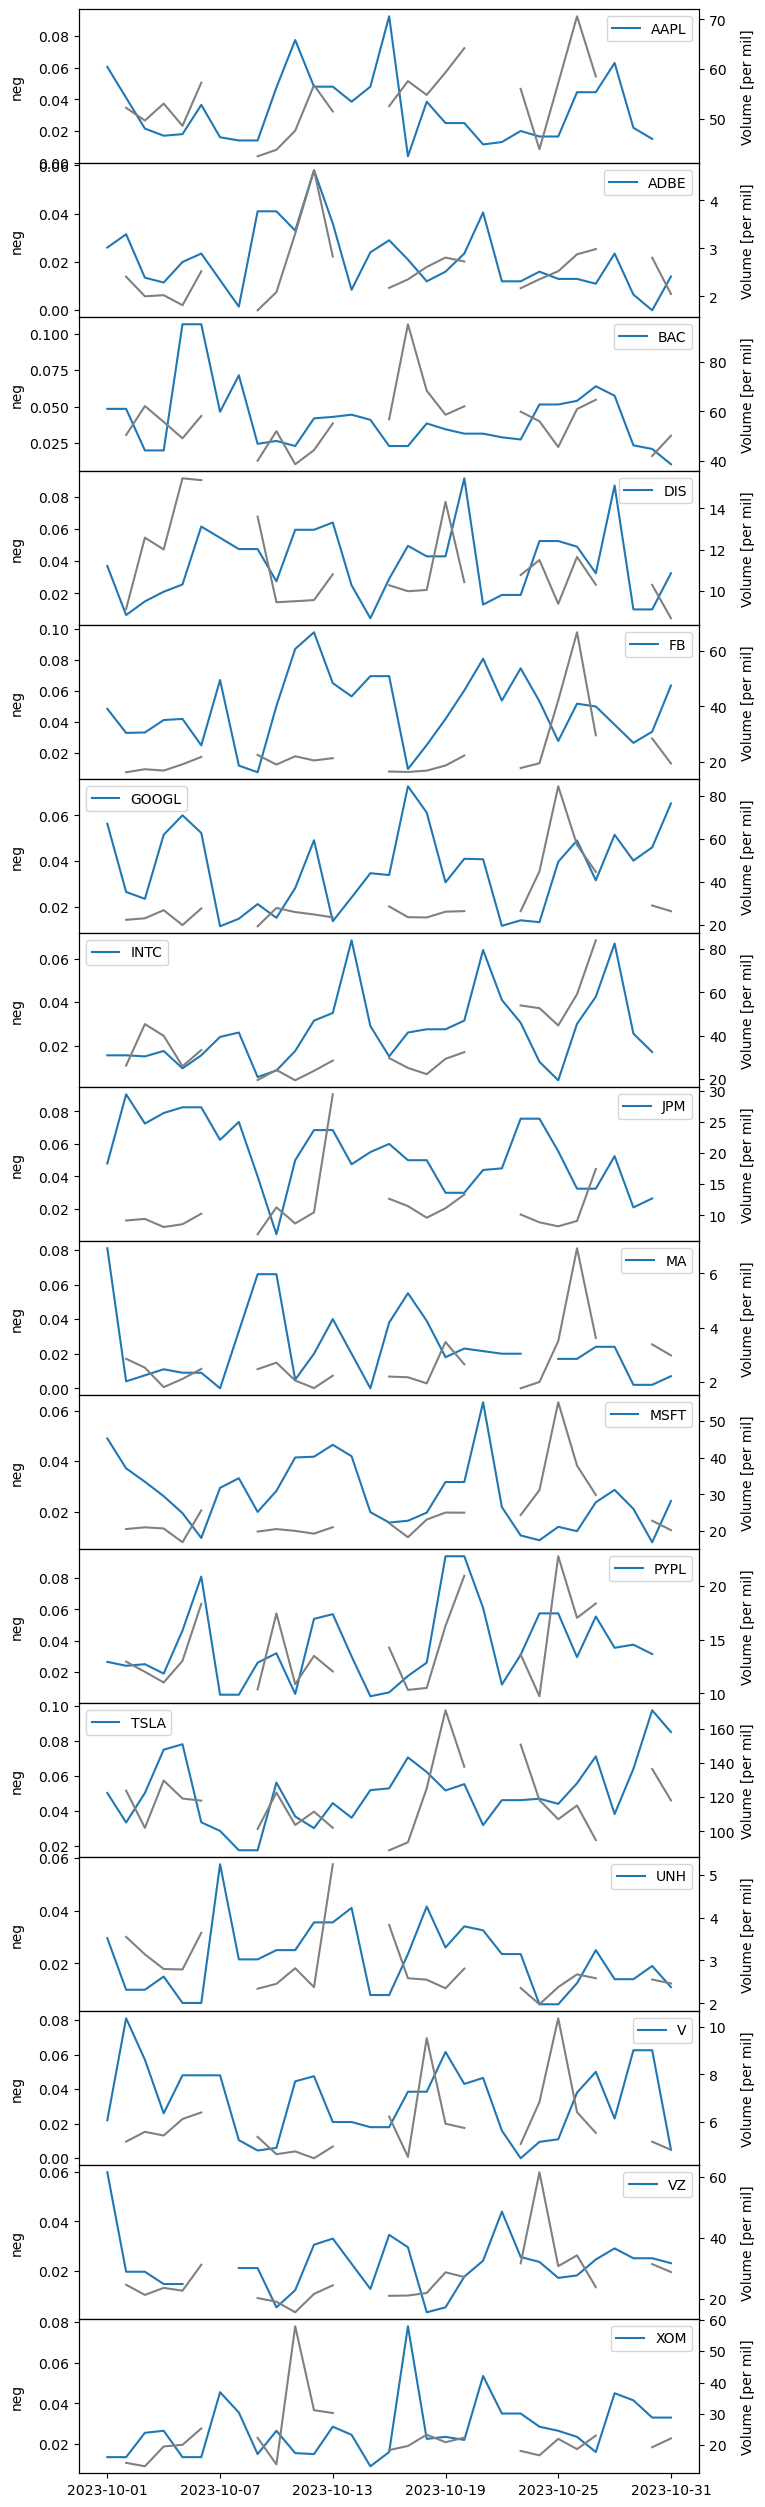

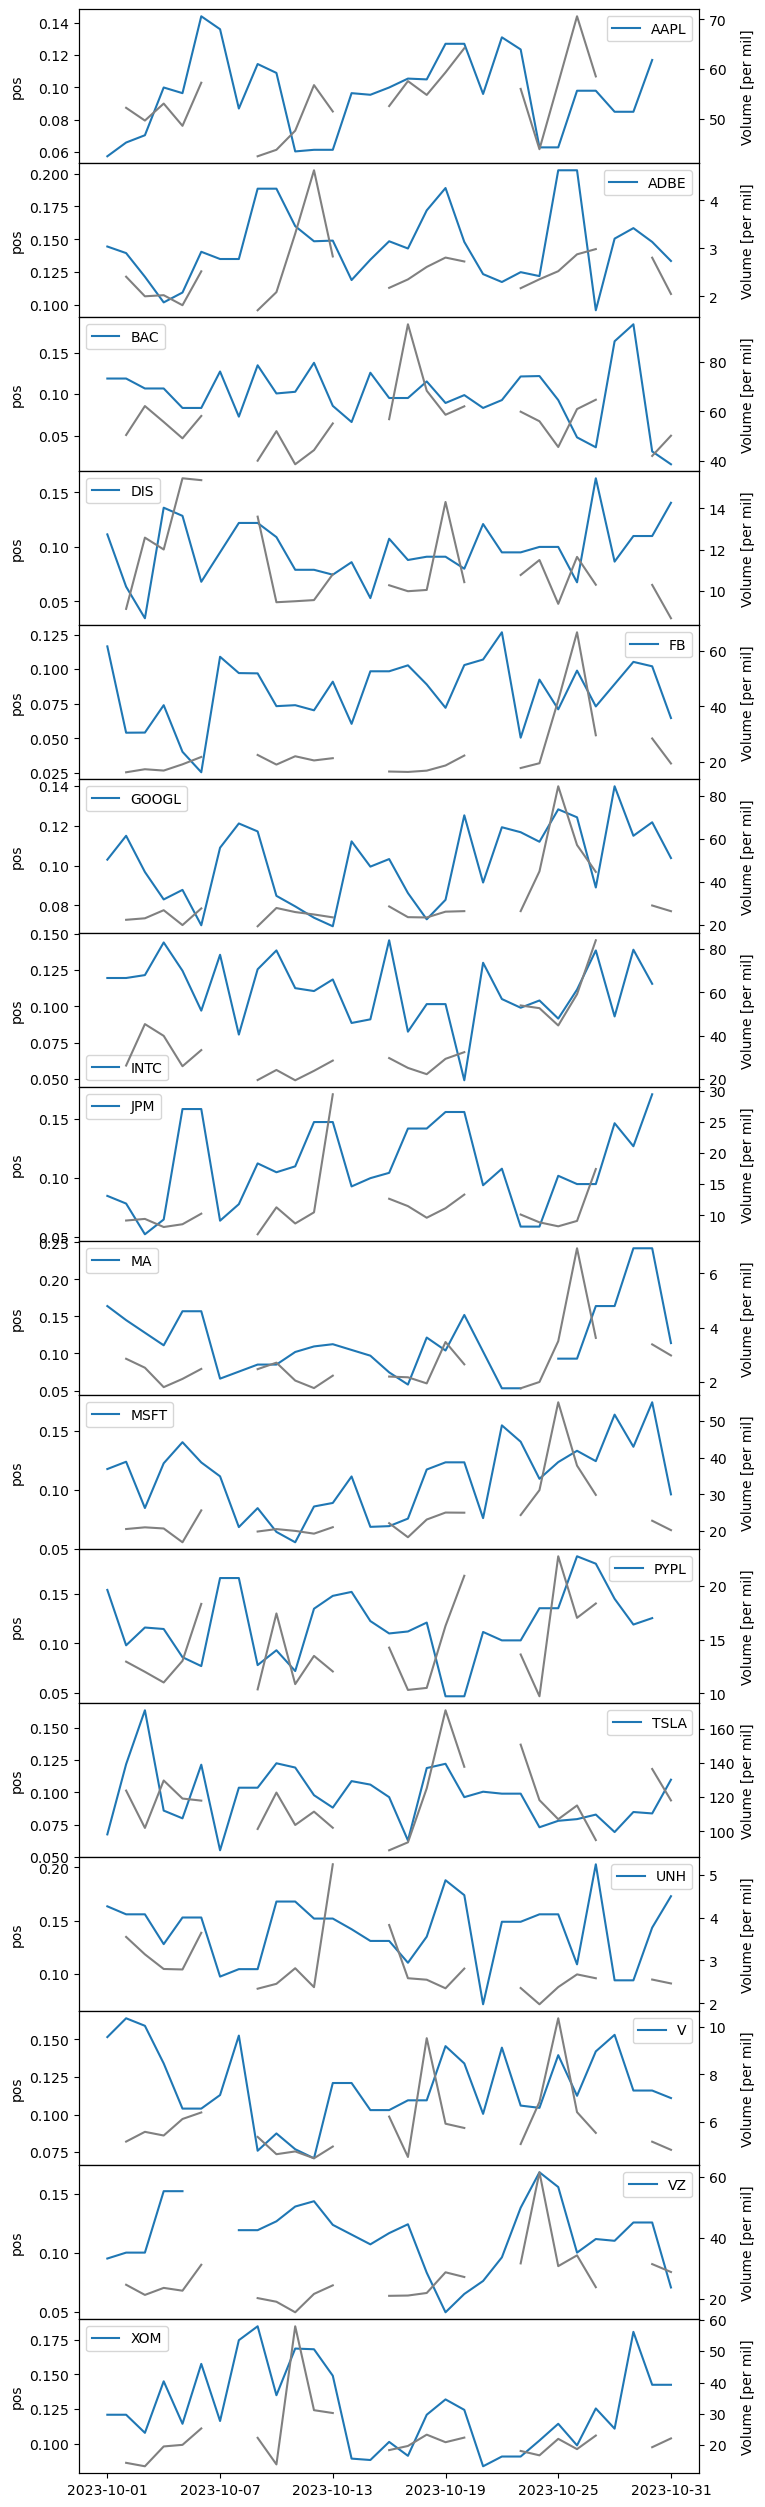

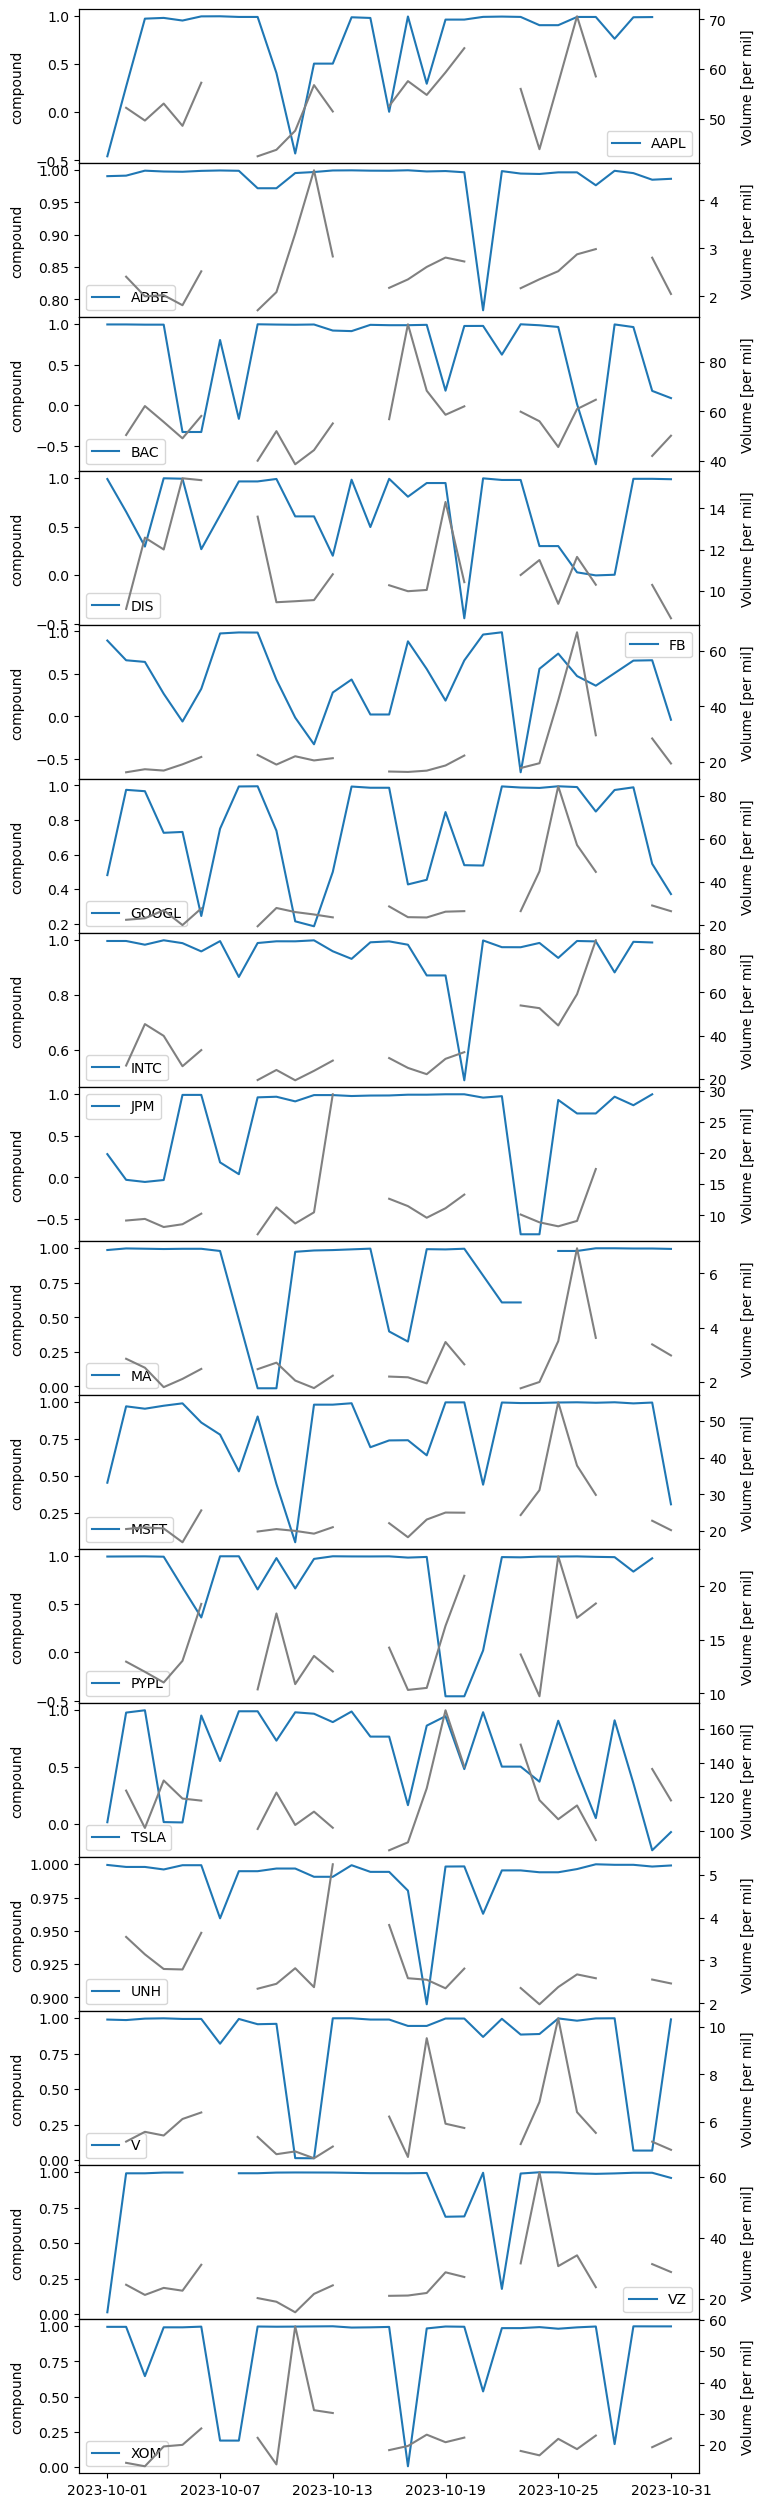

In [6]:
stocks = np.unique(data_combined['stock'])
nrows = len(stocks)

with PdfPages('multipage_pdf.pdf') as pdf:
    
    for score in ['neg', 'pos', 'compound']:
        
        fg, ax = plt.subplots(nrows=nrows, figsize=(8, nrows*2), sharex=True)    
        for i, stock in enumerate(stocks):
            mask = data_combined['stock']==stock

            mydata = data_combined[mask].sort_values(by=['date'],ignore_index=True)

            axj = ax[i].twinx()
            ax[i].plot(mydata['date'], mydata[score], label=stock)
            axj.plot(mydata['date'], mydata['volume']/1.0e6, label=stock, color='grey')

            ax[i].set_ylabel(score)
            axj.set_ylabel('Volume [per mil]')
            ax[i].legend()

        ax[0].xaxis.set_major_locator(plt.MaxNLocator(6))    
        fg.subplots_adjust(hspace=0.0)
        fg.align_labels()
        pdf.savefig(fg, bbox_inches='tight')